In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob 
from numpy.linalg import eig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from typing import List, Set, Dict, Tuple, Optional

import seaborn as sns
%matplotlib inline

In [36]:
# Get names of historical data files and store sector ETF tickers in a list 
data = [f for f in glob.glob('*.csv')]
tickers = [f[0:3] for f in data]

# Names of Sector ETFs
names = ["Mat", "Enrgy", "Fins", "Indu", "Tech", "Stpl", "Util", "Health", "Disc" ]

# Create a mapping from tickers to names (maybe useful)
tick_to_name = dict(zip(tickers,names))


#### Pull closing prices from each "sector".csv file into a Pandas Dataframe

In [38]:
df_sec = pd.concat([pd.read_csv(f, usecols=[0,5], index_col = [0]) for f in data], ignore_index = True, axis = 1)
df_sec.columns = names
df_sec.head()

,Mat,Enrgy,Fins,Indu,Tech,Stpl,Util,Health,Disc
Date,,,,,,,,,
1998-12-22,13.326187,16.030661,9.767839,16.370098,25.580147,17.100040,14.737362,19.090425,20.134567
1998-12-23,13.466161,16.364420,9.911845,16.655781,26.191339,17.513418,14.675605,19.519430,20.221031
1998-12-24,13.776071,16.278292,9.977332,16.875517,26.091562,17.483175,14.945813,19.638632,20.591616
1998-12-28,13.656102,16.192167,9.846398,16.963413,26.166361,17.382345,14.868592,19.352631,20.406319
1998-12-29,13.906034,16.353655,9.951146,17.205086,26.241230,17.765488,15.115628,19.781630,20.851015


#### Pull closing prices for the S&P 500

In [39]:
df_spx = pd.read_csv("SPX/^GSPC.csv", usecols = [0,5], index_col=[0], parse_dates=True)
df_spx.columns = ["SPX"]
df_spx.head()

,SPX
Date,
1998-12-22,1203.569946
1998-12-23,1228.540039
1998-12-24,1226.270020
1998-12-28,1225.489990
1998-12-29,1241.810059


#### Calculate returns for each sector and the S&P 500

In [40]:
ret_sec = df_sec.pct_change().dropna()
ret_spx = df_spx.pct_change().dropna()
ret_sec.head()

,Mat,Enrgy,Fins,Indu,Tech,Stpl,Util,Health,Disc
Date,,,,,,,,,
1998-12-23,0.010504,0.020820,0.014743,0.017452,0.023893,0.024174,-0.004191,0.022472,0.004294
1998-12-24,0.023014,-0.005263,0.006607,0.013193,-0.003810,-0.001727,0.018412,0.006107,0.018327
1998-12-28,-0.008709,-0.005291,-0.013123,0.005208,0.002867,-0.005767,-0.005167,-0.014563,-0.008999
1998-12-29,0.018302,0.009973,0.010638,0.014247,0.002861,0.022042,0.016615,0.022167,0.021792
1998-12-30,-0.002876,-0.015142,-0.003949,-0.004471,-0.003802,-0.006243,-0.008172,-0.008436,-0.008294


####   Sector ETF Correlation Matrix

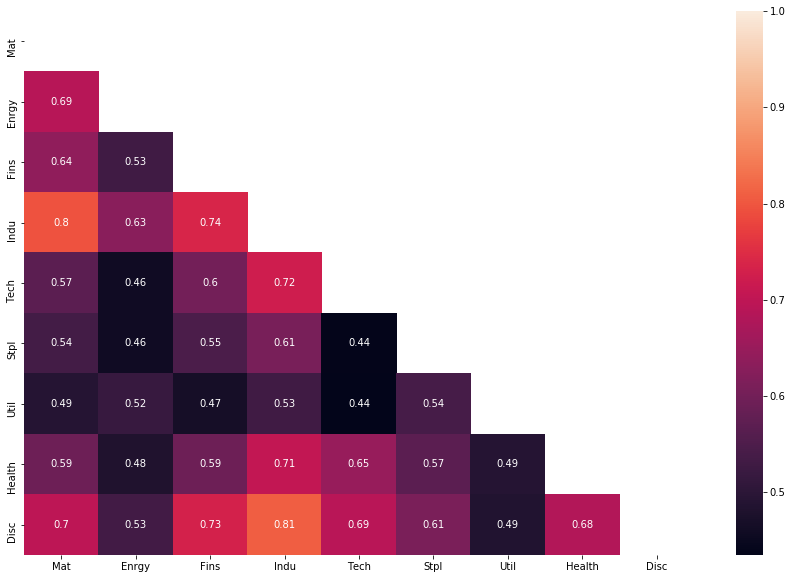

In [74]:
cor_mat = ret_sec.corr()

plt.figure(figsize =(15,10))
mask = np.zeros_like(cor_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor_mat, mask=mask, annot=True)

#### Three helper PCA functions

In [51]:
## Using Sci-kit learn - this functions takes sector returns as input and returns eigenvectors and eigenvalues 
## by performing a singular value decomposition
def get_eigen(returns: pd.DataFrame) -> Tuple [np.ndarray, np.ndarray]:
    
    #Noramlize data (mean - 0, std - 1)
    scaler = StandardScaler()
    scaled_ret = scaler.fit_transform(returns)

    pca = PCA()
    pca.fit(scaled_ret)
    
    return pca.explained_variance_ , pca.components_

In [52]:
# Function that returns the cumulative explained variance from a list of eigenvalues
def eig_val_xy(eig_val: np.ndarray) -> Tuple[List, List]:
    x = list(range(eig_val.size))
    y = [val / sum (eig_val) for val in eig_val]
    return x, y

In [53]:
# Function that plots each eigenvalue (bar) and the cumulative explained variance (line)
def plot_eig(eig_val: np.ndarray):
    x, y = eig_val_xy(eig_val)
    fig = figure()
    plt.figure(figsize =(15,10))
    plt.bar(x, y)
    plt.plot(np.cumsum(y), color = 'c')
    plt.title("Cumalative Explained Variance")
    return fig

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

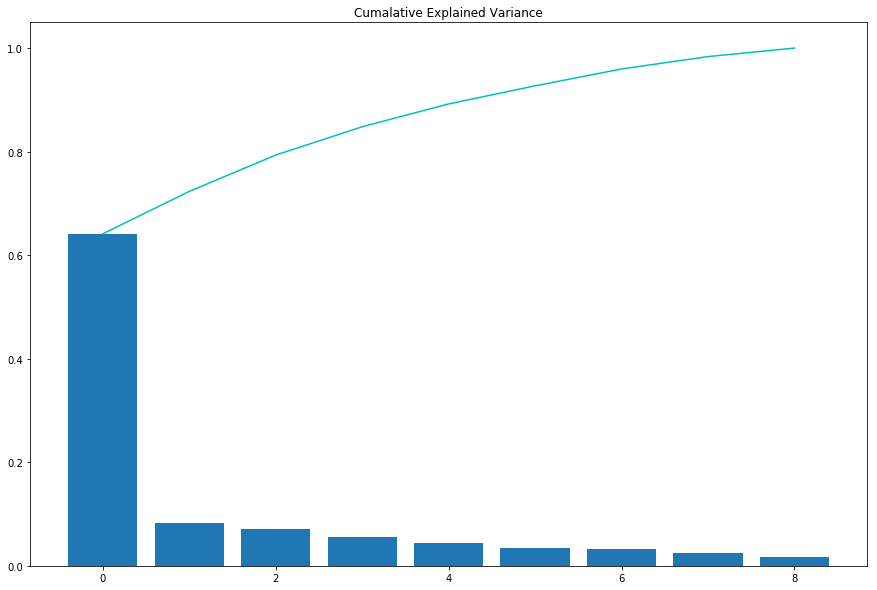

In [54]:
# Get Eigenvectors and Eigenvalues
eig_val, eig_vec = get_eigen(ret_sec)
plot_eig(eig_val)

#### Plot the First Eigenvector - shows a positive loading to each sector repersenting the "market" factor

<Figure size 432x288 with 0 Axes>

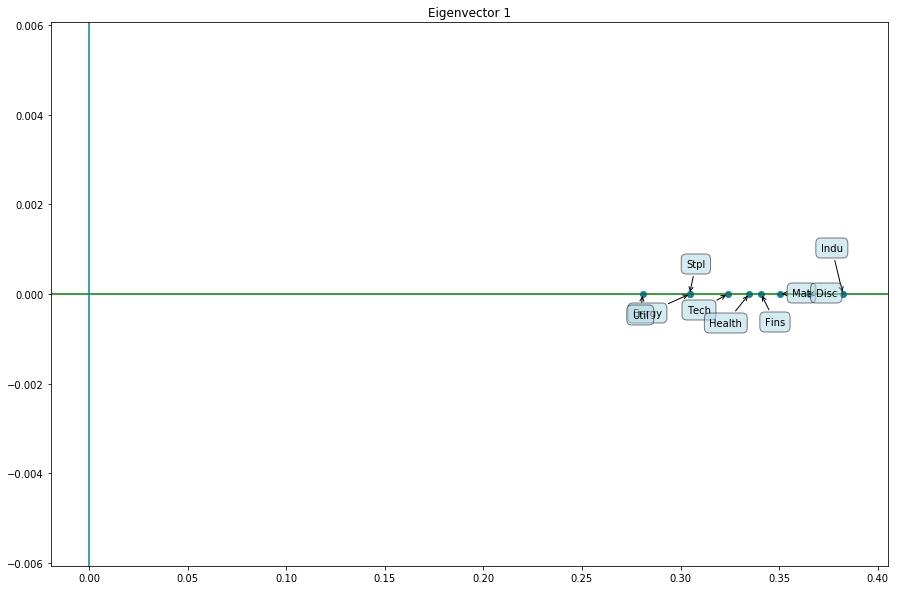

In [67]:
#Helper function which takes in a 2d array of eigenvectors and a variable repersenting which eigenvector you want to plot
def plot_eig_load(eig_vec, num):
    fig = figure()
    y1 = eig_vec[num,:]

    plt.figure(figsize =(15,10))
    plt.scatter(y1, [0]*9, marker = 'o')
    plt.axhline(y = 0, color = 'g')
    plt.axvline(x = 0, color = 'darkcyan')
    plt.title("Eigenvector {}".format(num+1))
    for label, x_, y_ in zip(names, y1, [0]*9):
        plt.annotate(
            label,
            xy=(x_, y_), xytext=(np.random.randint(low =-50, high =50), np.random.randint(low =-50, high =50)),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plot_eig_load(eig_vec,0)

#### Compare cumulative return of S&P 500 to the First Eigenvector

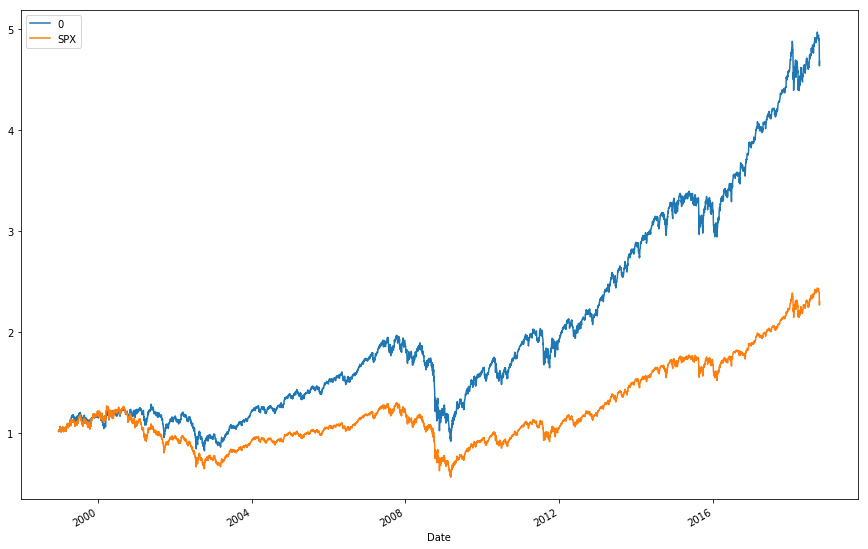

In [68]:
#Normalized eigen_vector (i.e., values sum to 1 - no leverage)
df_comp = pd.concat([ret_sec.dot(eig_vec[0]/sum(eig_vec[0])), df_spx_ret], axis = 1)
df_comp.index = df_spx_ret.index
(df_comp + 1).cumprod().plot(figsize = (15,10))


#### Plot Second Eigenvector - long cyclical stocks (higher beta), short lower beta stocks

<Figure size 432x288 with 0 Axes>

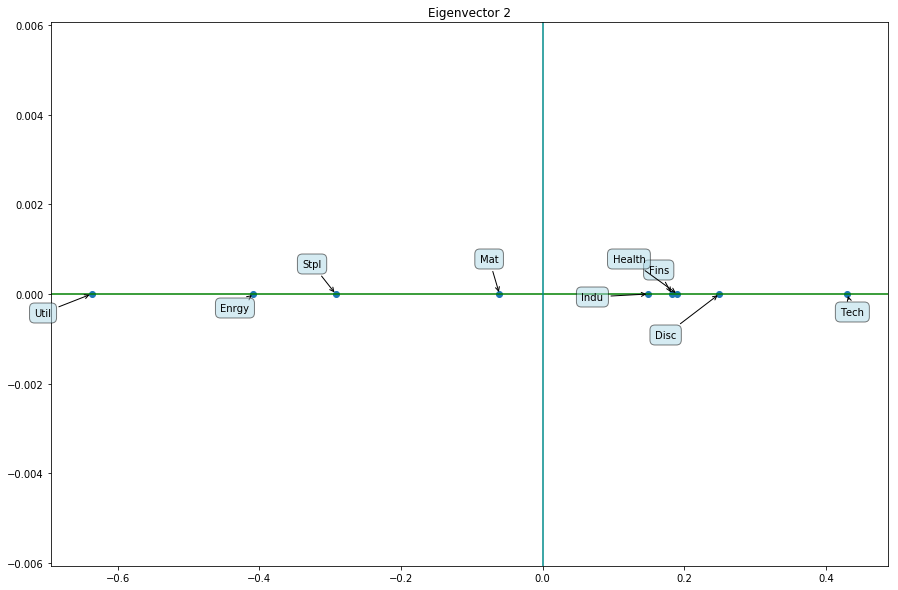

In [66]:
plot_eig_load(eig_vec,1)

In [86]:
## Rolling PCA
def eig_vec_calc(returns, window, start = 0):
    eig_val, _ = get_eigen(returns.iloc[start:start+window,:])
    x,y = eig_val_xy(eig_val)
    plt.figure(figsize =(15,10))
    plt.plot(np.cumsum(y), color = 'c')
    plt.ylim((0,1))
    plt.bar(x, y)
    plt.title('Date: {} - {}'.format(returns.index[start], returns.index[start+window]))

#### Interactive Widget that shows the perceante of explained variance of each eigenvector over time using different lookback periods

In [87]:
interact(eig_vec_calc, returns = fixed(ret_sec), window = (30,300,10), start = (0,4800,30))

interactive(children=(IntSlider(value=160, description='window', max=300, min=30, step=10), IntSlider(value=0,…

<function __main__.eig_vec_calc(returns, window, start=0)>

In [75]:
eig_val_x = []
for x in range(len(ret_sec.index)):
    eig_val, _ = get_eigen(ret_sec.iloc)
    x,y = eig_val_xy(eig_val)

In [85]:
l = len(ret_sec.index)
for x in range(0,l,100):
    print(x)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
